# Overall Reactor Comparison

### This notebooks compares different reactors with respect to SNF metrics, including the repository footprint and peak dose rates

In [79]:
%matplotlib inline
import math

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as tk 

import numpy as np
import seaborn as sns
from scipy.stats import pearsonr

pd.set_option('display.precision', 2)

In [80]:
# Load the csv files obtained with ...

reactors        = ['Ref_PWR', 'SPWR', 'HTGR', 'HPR', 'HTGR_FCM','SFR']
reactors_legend = reactors 

# Return a list containing the dataframe with the results for each reactors
def load_results(reactors):
    results = []
    for i in reactors:
        result = pd.read_csv('./Results/'+i+'/cooling'+i+'.csv', sep=',') # path to the csv files
        results.append(result)
    return results

In [81]:
# Change the index of the csv file. The time at discharge is 0. 
def set_cooling_time(results):    
    for i in range (len(results)):
        discharge = results[i].iloc[1, 0]
        results[i]['cooling time']=(results[i].iloc[:, 0]-discharge)/365
        results[i].set_index('cooling time', inplace=True)
    return results

In [82]:
# Load the results
results = load_results(reactors)
results = set_cooling_time(results)

# Functions to customize the chart

In [83]:
# Function to add value labels on the bar chart
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center')

# SNF mass and volumes

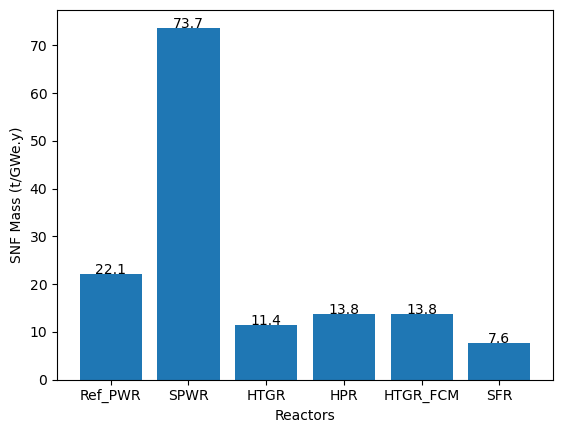

In [84]:
# Create a bar chart with the values of the SNF mass for each reactor

N_mass   = results[0].columns.get_loc("SNF mass (t/GWe.y)") # read the SNF mass index of columns in the dataframe
SNF_mass = [results[i].iloc[0,N_mass] for i in range (len(results))] # create a list with the SNF mass for each reactor
SNF_mass_labels = [round(x, 1) for x in SNF_mass]
plt.bar(x=reactors_legend, height=SNF_mass)
plt.xlabel('Reactors')
plt.ylabel('SNF Mass (t/GWe.y)') 
addlabels(reactors, SNF_mass_labels)
#plt.title ('Mass of spent nuclear fuel') 

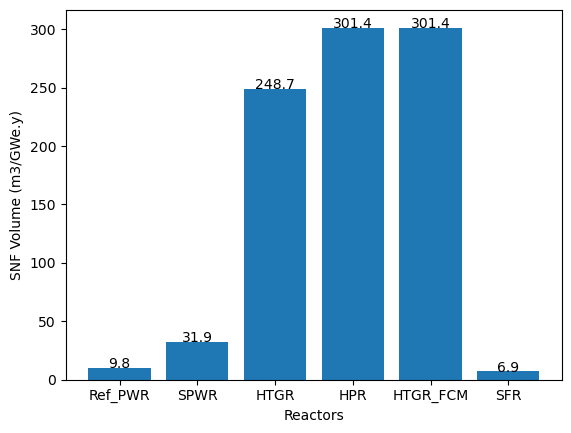

In [85]:
# Create a bar chart with the values of SNF volume for each reactor

N_vol    = results[0].columns.get_loc("SNF volume (m3/(GWe.y))") # get the column index of the SNF volume in the dataframe
SNF_vol  = [results[i].iloc[0,N_vol] for i in range (len(results))] # create a list with the SNF volume
SNF_vol_labels = [round(x,1) for x in SNF_vol]
plt.bar(x = reactors_legend, height=SNF_vol)
plt.xlabel('Reactors')
plt.ylabel('SNF Volume (m3/GWe.y)') 
#plt.title ('Volume of spent nuclear fuel') 
addlabels(reactors, SNF_vol_labels)

# Activity

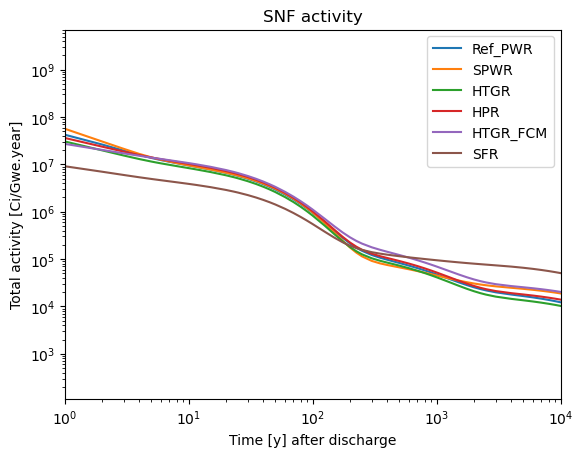

In [86]:
# Plot the evolution of the activity for each reactor after discharge

fig,ax = plt.subplots()
for i in results:
    i.plot(ax=ax, y=['Activity (Ci/GWe.y)'])
ax.set_xlabel('Time [y] after discharge')
ax.set_ylabel('Total activity [Ci/Gwe.year]') 
ax.set_title ('SNF activity') 
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim((1,1e4))
ax.legend(reactors)

# Decay heat

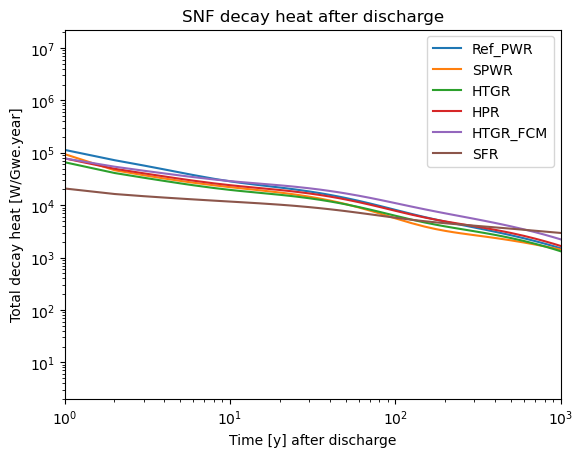

In [87]:
# Plot the evolution of the decay heat after discharge for each reactor
fig,ax= plt.subplots()
for i in results:
    i.plot(ax=ax, y='Decay heat (W/GWe.y)')
ax.set_xlabel('Time [y] after discharge')
ax.set_ylabel('Total decay heat [W/Gwe.year]') 
ax.set_title ('SNF decay heat after discharge') 
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim((1,1e3))
ax.legend(reactors)

# Radiotoxicity

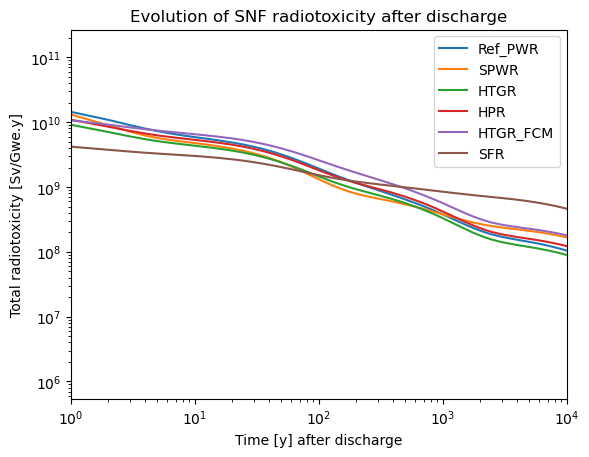

In [88]:
# Plot the evolution of the total radiotoxicity after discharge for each reactor

fig,ax = plt.subplots()
for i in results:
    i.plot(ax=ax, y='Radiotoxicity (Sv/GWe.y)')
ax.set_xlabel('Time [y] after discharge')
ax.set_ylabel('Total radiotoxicity [Sv/Gwe.y]') 
ax.set_title ('Evolution of SNF radiotoxicity after discharge') 
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim((1,1e4))
ax.legend(reactors)

# I129

In [89]:
# I129 properties
peak_dose = pd.read_csv('I129dose_max.csv')
peak_dose

,Unnamed: 0,Ref_PWR,SPWR,HTGR,HPR,HTGR_FCM,SFR
0,0,1.03e-16,6.76e-17,2.24e-20,2.53e-20,3.73e-20,2.23e-16


# Repository

In [90]:
df_rep_footprint=pd.read_csv('rep_foot_print.csv')
df_rep_footprint

,Unnamed: 0,"Minimum,m^2",n_wf,#packages per GWe.y,Decay heat (W/Pkg)
0,Ref_PWR,1140.42,1,48.09,285.42
1,SPWR,957.82,4,40.07,262.14
2,HTGR,757.04,42,31.58,329.14
3,HPR,951.57,42,38.28,336.20
4,HTGR_FCM,1472.27,18,36.23,463.02
5,SFR,850.67,3,25.75,299.24


# Summary of the results and comparison with the reference

In [91]:
# Enable to select the nearest index to the time in the results
## for example to select the activity at 10y, return the index the closest to 10 y and the corresponding value

def select_time(result, time ):
    res=result.copy(deep=True)
    res['time']=res.index.tolist()
    idx= res['time'].sub(time).abs().idxmin()
    return idx
    

In [92]:
# Create a dataframe with the parameters of interest and select the corresponding values for each reactor

df = []
for i in range (len(results)): # iterate on the list of reactors
    result=results[i].copy(deep=True)
    d = []
    d.append(SNF_mass[i])
    d.append(SNF_vol[i])    
    idx=select_time(result, 50) # select the index for 10y
    d.append(result.loc[idx, 'Decay heat (W/GWe.y)'])
    
    idx=select_time(result, 10000) # Select the index for 100,000 years
    d.append(result.loc[idx, 'Radiotoxicity (Sv/GWe.y)'])
    
    d.append(df_rep_footprint.iloc[i,1]) # footprint
    d.append(peak_dose.iloc[0,i+1])

    df.append(d)
    
df=pd.DataFrame(df, columns=['SNF mass (t/GWe.y)','SNF volume(m3/GWe.y)', 'Decay heat 50y (W/GWe.year)',
                           'Radiotoxicity 10000y (Sv/GWe.y)','Repo. Footprint, m^2','Peak dose rate, (mSv/yr)/GWe.y'])
df.index=reactors

In [93]:
df

,SNF mass (t/GWe.y),SNF volume(m3/GWe.y),Decay heat 50y (W/GWe.year),Radiotoxicity 10000y (Sv/GWe.y),"Repo. Footprint, m^2","Peak dose rate, (mSv/yr)/GWe.y"
Ref_PWR,22.12,9.76,13725.90,1.04e+08,1140.42,1.03e-16
SPWR,73.74,31.93,10505.13,1.67e+08,957.82,6.76e-17
HTGR,11.41,248.66,10393.88,8.95e+07,757.04,2.24e-20
HPR,13.83,301.40,12868.83,1.22e+08,951.57,2.53e-20
HTGR_FCM,13.83,301.40,16775.64,1.80e+08,1472.27,3.73e-20
SFR,7.60,6.94,7704.38,4.63e+08,850.67,2.23e-16


In [94]:
# Create a dataframe with the value of the ratio with the reference reactor

reference_reactor='Ref_PWR'
ratio=pd.DataFrame()
for i in df.columns:
    ref_value = df.loc[reference_reactor, i]
    ratio[i]  = df[i]/ref_value

ratio


,SNF mass (t/GWe.y),SNF volume(m3/GWe.y),Decay heat 50y (W/GWe.year),Radiotoxicity 10000y (Sv/GWe.y),"Repo. Footprint, m^2","Peak dose rate, (mSv/yr)/GWe.y"
Ref_PWR,1.00,1.00,1.00,1.00,1.00,1.00e+00
SPWR,3.33,3.27,0.77,1.60,0.84,6.54e-01
HTGR,0.52,25.49,0.76,0.86,0.66,2.17e-04
HPR,0.62,30.90,0.94,1.17,0.83,2.45e-04
HTGR_FCM,0.62,30.90,1.22,1.72,1.29,3.61e-04
SFR,0.34,0.71,0.56,4.43,0.75,2.16e+00


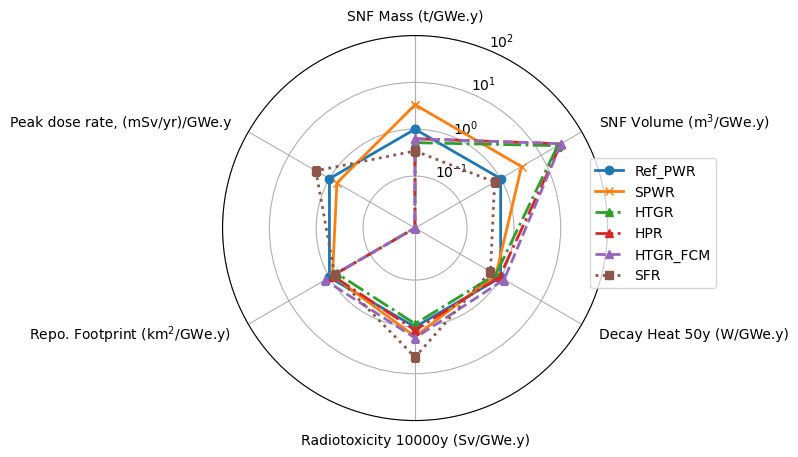

In [95]:
# Create a radar chart with the values of the ratio dataframe

# Set data
df = ratio.transpose()

category = df.index.tolist()
category =[*category, category[0]]

# For each reactor create a list with the values of the metrics
react=[]
for i in df.columns:
    l=df[i].tolist()
    l=[*l, l[0]]
    react.append(l)

# Set the location of the legend
label_loc = np.linspace(start=0, stop=2 * np.pi, num=len(category))

fig, ax = plt.subplots(figsize=(5,5), subplot_kw=dict(polar=True))

linestyle=['-', '-', '-.', '-.', '--', ':',':'] 
marker=["o", "x", "^", "^", "^", "s", "*", 'D']

# For each reactor, plot the line linking the parameters value
n=0
for i in react:
    ax.plot(label_loc, i, lw=2, ls=linestyle[n], marker=marker[n] )
    n+=1

ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

# align the labels
for label, angle in zip(ax.get_xticklabels(), label_loc):
    if angle in (0, np.pi):
        label.set_horizontalalignment('center')
    elif 0 < angle < np.pi:
        label.set_horizontalalignment('left')
    else:
        label.set_horizontalalignment('right')
ax.set_yscale('symlog', linthresh=0.1)
ax.set_ylim(0,100)


ax.legend(reactors_legend, loc='best', bbox_to_anchor=(1.3, 0.7), ncols=1)


labels_graph=['SNF Mass (t/GWe.y)','SNF Volume (m$^3$/GWe.y)', 'Decay Heat 50y (W/GWe.y)',
                           'Radiotoxicity 10000y (Sv/GWe.y)','Repo. Footprint (km$^2$/GWe.y)','Peak dose rate, (mSv/yr)/GWe.y','']

lines, labels = plt.thetagrids(np.degrees(label_loc), labels=labels_graph)



plt.show()